In [1]:
import time
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt


mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

C:\Users\wtais\Anaconda3\envs\hackthewind\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [7]:
class VAE():
    
    def __init__(self,beta=1,latent_dim=20,batch_size=1000,learning_rate=1e-4,network_type='fully_connected'):
        self.beta=beta
        self.network_type = network_type
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.x = tf.placeholder('float', [None, 784], name='x')
        self._build_network()
        self._vae_loss_and_optimizer()
        
        # Initializing the tensorflow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _build_network(self):
        if self.network_type is 'fully_connected':
            self._initialize_weights_fc()
            self._encoder_fc(self.x)
            self._sample_z()
            self._decoder_fc()
  
    def _initialize_weights_fc(self):
        encoder_hl1_nodes = 512
        encoder_out_nodes = 512
        decoder_hl1_nodes = 512
        decoder_out_nodes = 512
        initializer = tf.contrib.layers.xavier_initializer()
        
        self.encoder_input = {'weights':tf.Variable(initializer([784, encoder_hl1_nodes]), name='encoder_input_w'),
                          'biases':tf.Variable(initializer([encoder_hl1_nodes]), name='encoder_input_b')}

        self.encoder_hidden_1 = {'weights':tf.Variable(initializer([encoder_hl1_nodes, encoder_out_nodes]), name='encoder_h1_w'),
                          'biases':tf.Variable(initializer([encoder_out_nodes]), name='encoder_h1_b')}

        self.encoder_output_mu = {'weights':tf.Variable(initializer([encoder_out_nodes, self.latent_dim]), name='encoder_out_mu_w'),
                        'biases':tf.Variable(initializer([self.latent_dim]), name='encoder_out_mu_b')}

        self.encoder_output_log_sigma = {'weights':tf.Variable(initializer([encoder_out_nodes, self.latent_dim]), name='encoder_out_log_sigma_w'),
                        'biases':tf.Variable(initializer([self.latent_dim]), name='encoder_out_log_sigma_b')}
        
        self.decoder_input = {'weights':tf.Variable(initializer([self.latent_dim, decoder_hl1_nodes]), name='decoder_input_w'),
                          'biases':tf.Variable(initializer([encoder_hl1_nodes]), name='decoder_input_b')}

        self.decoder_hidden_1 = {'weights':tf.Variable(initializer([decoder_hl1_nodes, decoder_out_nodes]), name='decoder_h1_w'),
                          'biases':tf.Variable(initializer([encoder_out_nodes]), name='decoder_h1_b')}

        self.decoder_output = {'weights':tf.Variable(initializer([decoder_out_nodes, 784]), name='decoder_output_w'),
                        'biases':tf.Variable(initializer([784]), name='decoder_output_b')}
        
    def _encoder_fc(self, data):
        l1 = tf.add(tf.matmul(data,self.encoder_input['weights']), self.encoder_input['biases'])
        l1 = tf.nn.relu(l1)
        l1 = tf.layers.batch_normalization(l1)

        self.z_mu = tf.add(tf.matmul(l1,self.encoder_output_mu['weights']), self.encoder_output_mu['biases'])
        self.z_log_sigma = tf.add(tf.matmul(l1,self.encoder_output_log_sigma['weights']), self.encoder_output_log_sigma['biases'])
        
    def _decoder_fc(self):
        l1 = tf.add(tf.matmul(self.z,self.decoder_input['weights']), self.decoder_input['biases'])
        l1 = tf.nn.relu(l1)
        l1 = tf.layers.batch_normalization(l1)

        out = tf.add(tf.matmul(l1,self.decoder_output['weights']), self.decoder_output['biases'])
        self.x_reconstruction_mean = tf.nn.sigmoid(out)

    def _sample_z(self):
        # sample z using reparameterization trick
        epsilon = tf.random_normal(shape=[self.batch_size, self.latent_dim],mean=0.0, stddev=1.0, name='epsilon', dtype='float32')
        self.z = tf.add(self.z_mu,tf.multiply(epsilon, tf.exp(0.5 * self.z_log_sigma)), name='z')
        
    def _vae_loss_and_optimizer(self):
        self.recon = tf.reduce_mean(tf.reduce_sum(tf.keras.backend.binary_crossentropy(self.x, self.x_reconstruction_mean)))
        # KL divergence between q(z|x) and p(z)
        self.kl = tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(self.z_log_sigma) + tf.square(self.z_mu) - 1 - self.z_log_sigma, 1))

        self.loss = self.recon + self.beta*self.kl
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

    def fit(self, x_batch):
        return self.sess.run([self.optimizer, self.loss, self.recon, self.kl], \
                             feed_dict={self.x: x_batch})
                
    def reconstruct_X(self, x_true):
        return self.sess.run(self.x_reconstruction_mean, feed_dict={self.x: x_true})
    
    def generate(self, z_mu=None):
        if z_mu is None:
            z_mu = np.random.normal(size=[self.batch_size, self.latent_dim])
        return self.sess.run(self.x_reconstruction_mean, 
                             feed_dict={self.z: z_mu})
    
    def get_z_mean(self, x_test):
        return self.sess.run(self.z_mu, feed_dict={self.x: x_test})

#### Instantiate VAE and Saver

In [8]:
vae = VAE(beta=1,batch_size=1000,learning_rate=1e-4,network_type='fully_connected',latent_dim=2)
saver = tf.train.Saver()

#### Training

In [9]:
def draw_digits_latent_space(z_mean_test, test_label):
    plt.scatter(z_mean_test[:,0],z_mean_test[:,1],c=test_label,cmap=plt.cm.get_cmap('jet', 10))
    plt.colorbar()
    plt.show()

In [10]:
# Initialization
list_of_latent_spaces = []
list_of_z_mu = []

hm_epochs = 1000

# for plotting latent space every 50 epochs
MM = vae.batch_size
grid_max = 100.0
z_test1 = np.linspace(grid_max,-grid_max,MM)
z_test2 = np.linspace(grid_max,-grid_max,MM)
zz = np.array([z_test1,z_test2])
zz = np.transpose(zz)

history_loss = []
history_recon = []
history_kl = []
epoch_loss = 0
recon_loss = 0
kl_loss = 0


Epoch 1 / 1000 ; average loss: 469.2041426136363; Reconstruction loss :  469.1800499999998; KL loss 0.02409047099893744


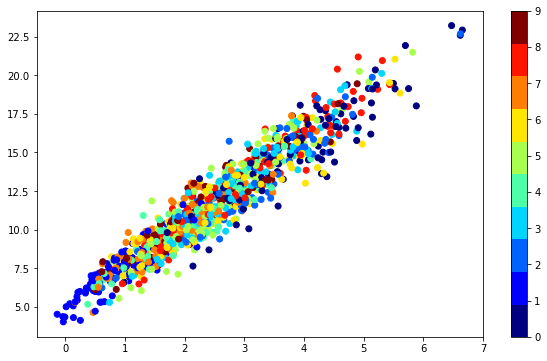

Epoch 11 / 1000 ; average loss: 2495.337588920455; Reconstruction loss :  2491.791586079546; KL loss 3.5459998730486104


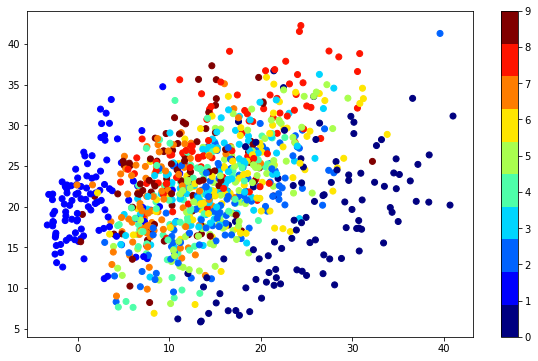

Epoch 21 / 1000 ; average loss: 4274.32240056819; Reconstruction loss :  4266.8565514204565; KL loss 7.465844971370706


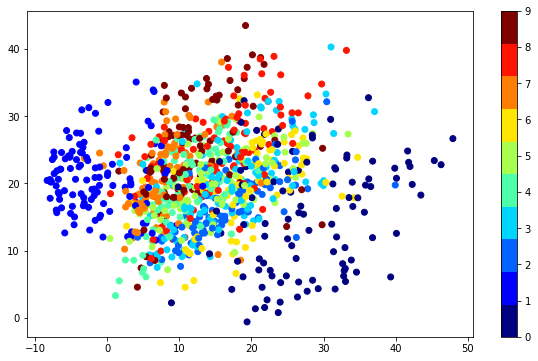

Epoch 31 / 1000 ; average loss: 5992.933558238653; Reconstruction loss :  5981.845045170452; KL loss 11.088511745496238


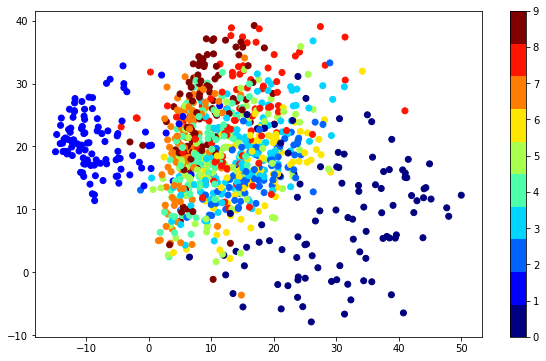

Epoch 41 / 1000 ; average loss: 7670.888046306834; Reconstruction loss :  7656.597836647724; KL loss 14.290205957698811


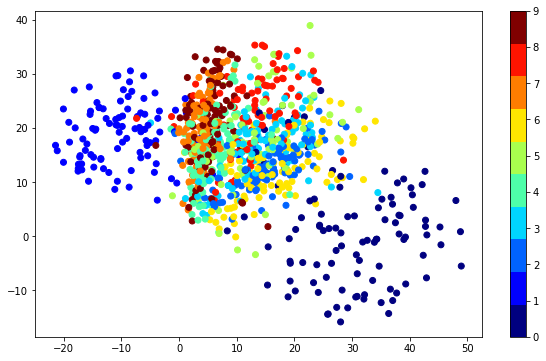

Epoch 51 / 1000 ; average loss: 9306.862086931835; Reconstruction loss :  9289.796320170453; KL loss 17.06576425487344


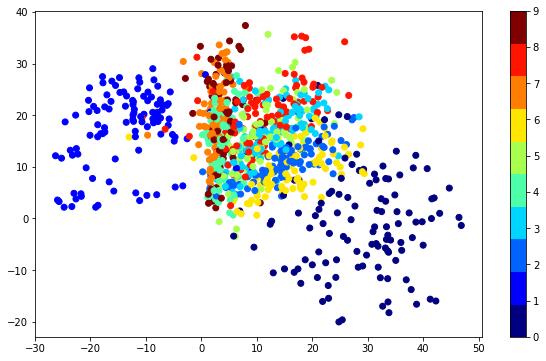

Epoch 61 / 1000 ; average loss: 10911.954492329569; Reconstruction loss :  10892.405165056824; KL loss 19.549323599633336


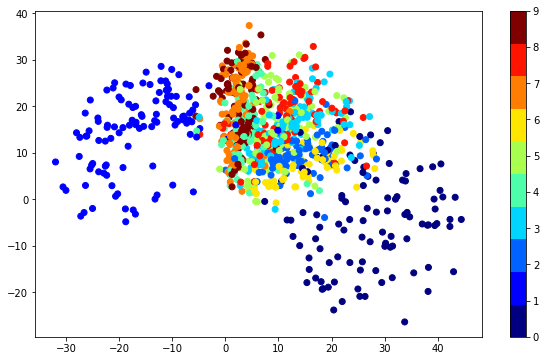

Epoch 71 / 1000 ; average loss: 12495.358675568192; Reconstruction loss :  12473.497043750012; KL loss 21.861628346781302


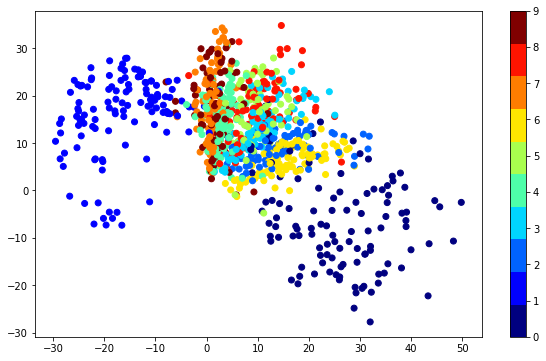

Epoch 81 / 1000 ; average loss: 14062.124261079567; Reconstruction loss :  14038.01258721589; KL loss 24.111668053757047


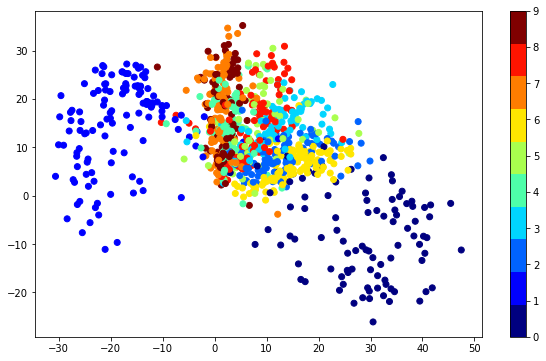

Epoch 91 / 1000 ; average loss: 15615.585473579577; Reconstruction loss :  15589.232201988616; KL loss 26.353266344772702


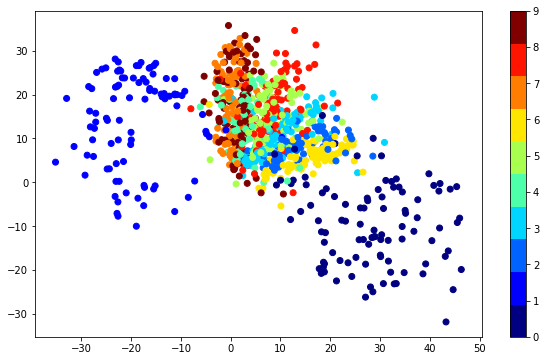

Epoch 101 / 1000 ; average loss: 17157.507411079572; Reconstruction loss :  17128.902846590896; KL loss 28.604558666550023


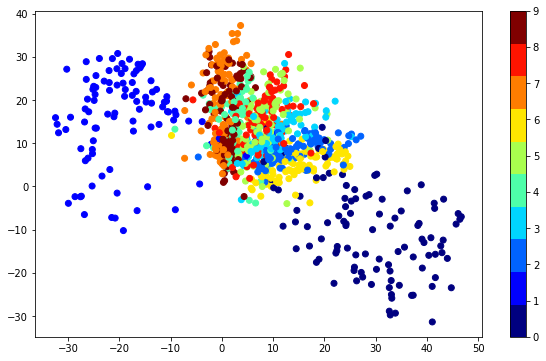

Epoch 111 / 1000 ; average loss: 18688.95185710231; Reconstruction loss :  18658.070171022726; KL loss 30.881678187535012


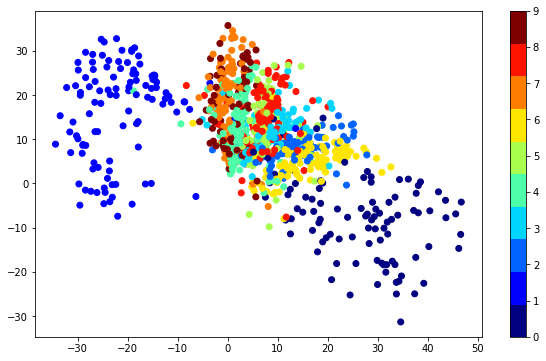

Epoch 121 / 1000 ; average loss: 20210.678900284114; Reconstruction loss :  20177.485726136372; KL loss 33.193165320491715


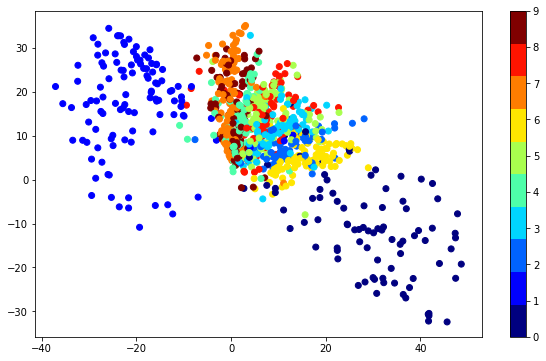

Epoch 131 / 1000 ; average loss: 21723.055532954553; Reconstruction loss :  21687.51341420457; KL loss 35.54210888932828


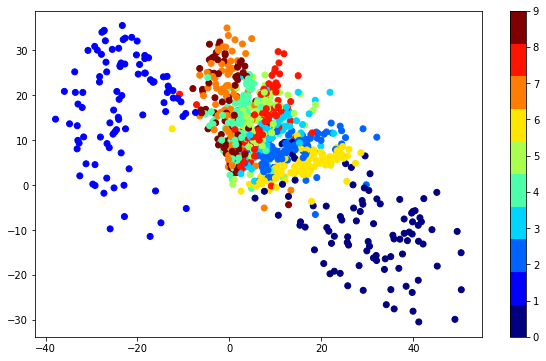

Epoch 141 / 1000 ; average loss: 23226.475119034065; Reconstruction loss :  23188.54635937506; KL loss 37.92874961808798


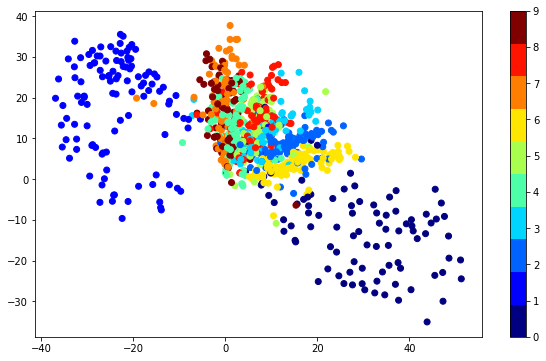

Epoch 151 / 1000 ; average loss: 24721.10979090908; Reconstruction loss :  24680.758536931873; KL loss 40.35124377424925


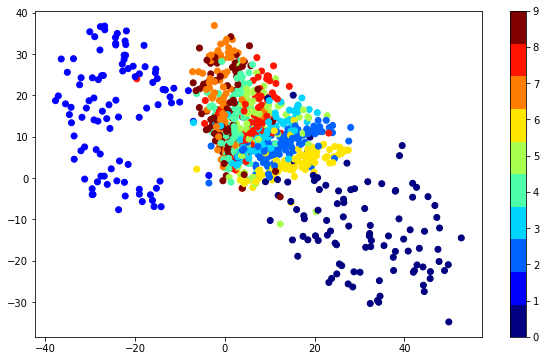

Epoch 161 / 1000 ; average loss: 26206.997548863656; Reconstruction loss :  26164.185677272762; KL loss 42.81186125887951


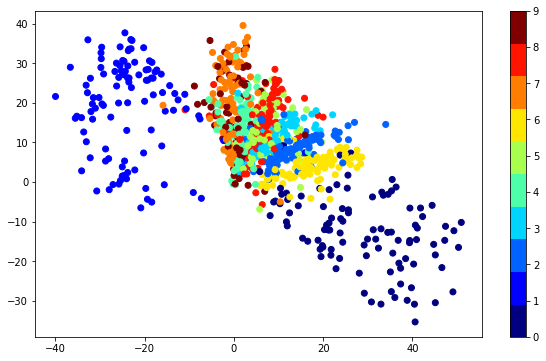

Epoch 171 / 1000 ; average loss: 27684.609716477265; Reconstruction loss :  27639.296080397802; KL loss 45.31362160600309


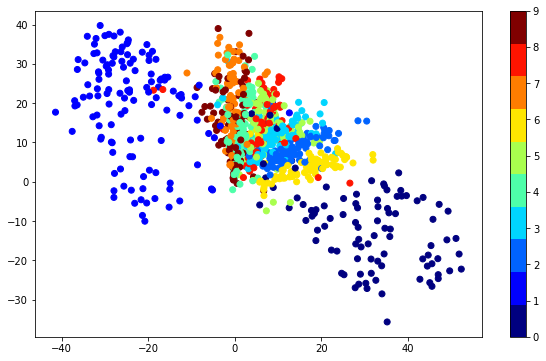

Epoch 181 / 1000 ; average loss: 29154.746696590882; Reconstruction loss :  29106.89134545466; KL loss 47.855336608166965


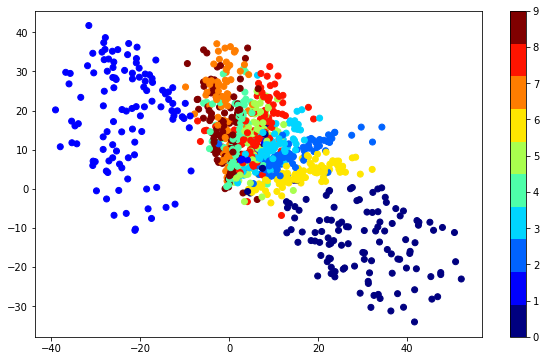

Epoch 191 / 1000 ; average loss: 30618.074071306793; Reconstruction loss :  30567.632129261474; KL loss 50.44192632096873


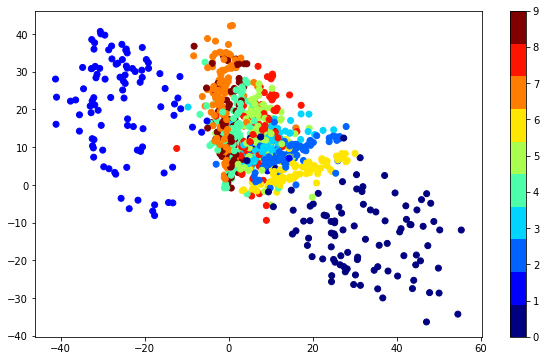

Epoch 201 / 1000 ; average loss: 32075.185415909065; Reconstruction loss :  32022.113601136487; KL loss 53.071797563700024


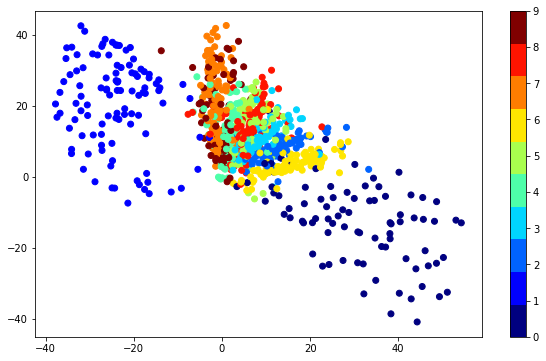

Epoch 211 / 1000 ; average loss: 33526.62638210226; Reconstruction loss :  33470.88191534104; KL loss 55.744451075163504


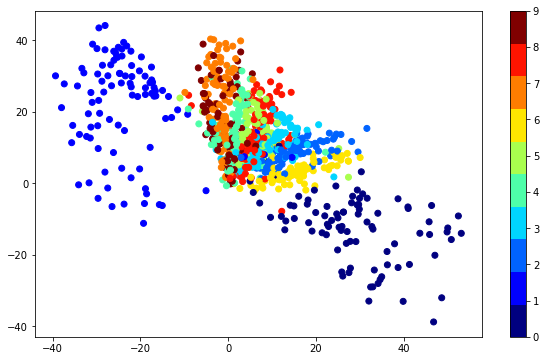

Epoch 221 / 1000 ; average loss: 34972.76792755682; Reconstruction loss :  34914.30864914785; KL loss 58.45926624295472


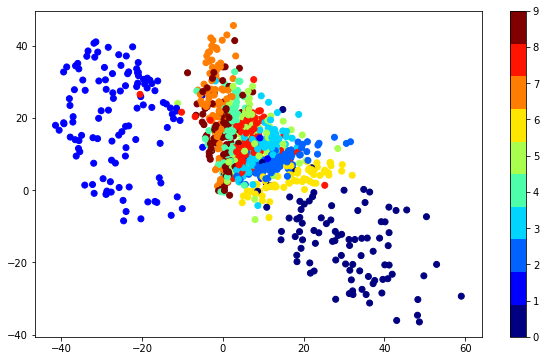

Epoch 231 / 1000 ; average loss: 36413.9941315341; Reconstruction loss :  36352.77675795469; KL loss 61.217359407017256


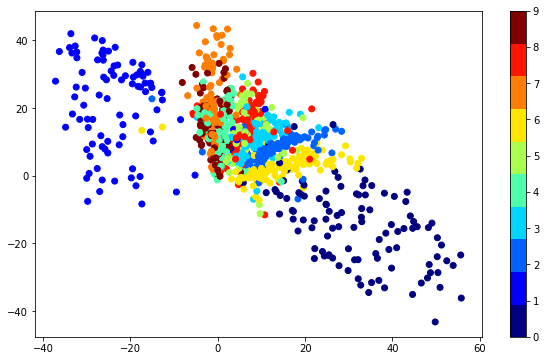

Epoch 241 / 1000 ; average loss: 37850.59059971594; Reconstruction loss :  37786.57532329561; KL loss 64.01525861910892


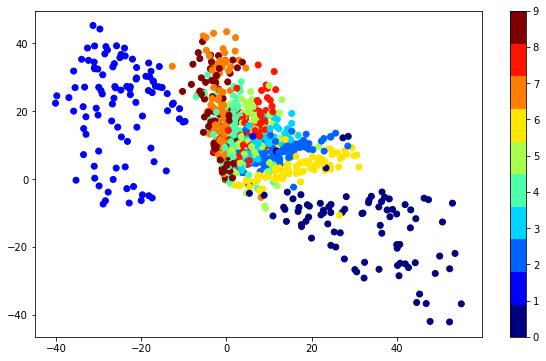

Epoch 251 / 1000 ; average loss: 39282.83047755672; Reconstruction loss :  39215.97834176154; KL loss 66.85211883361988


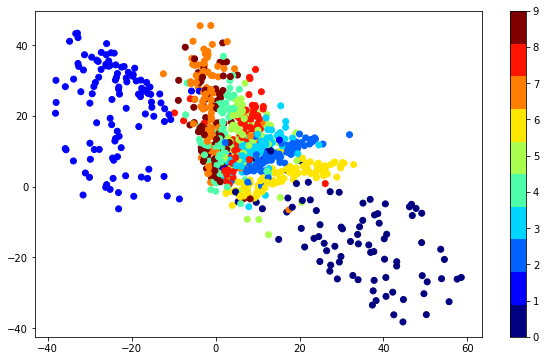

Epoch 261 / 1000 ; average loss: 40710.984796306766; Reconstruction loss :  40641.25792357972; KL loss 69.72685648121406


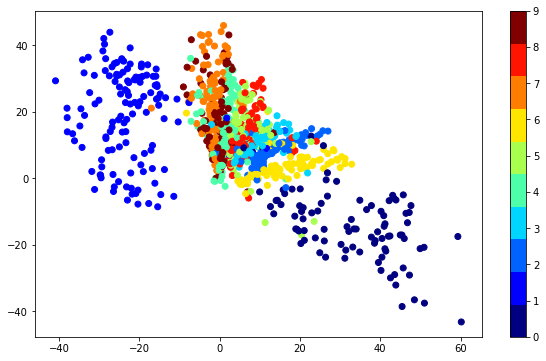

Epoch 271 / 1000 ; average loss: 42135.21114232938; Reconstruction loss :  42062.57462386385; KL loss 72.63650046925105


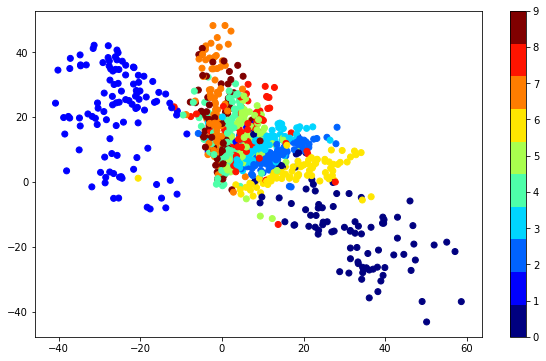

Epoch 281 / 1000 ; average loss: 43555.7855749999; Reconstruction loss :  43480.20471931839; KL loss 75.58083719909835


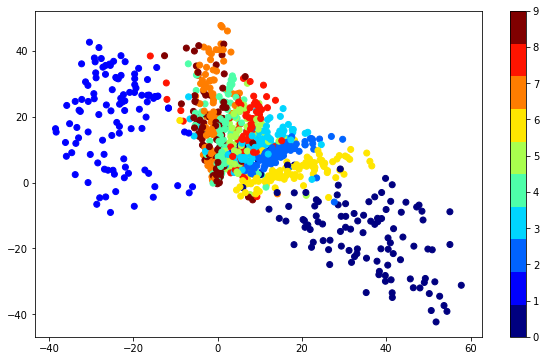

Epoch 291 / 1000 ; average loss: 44972.83681249988; Reconstruction loss :  44894.27987755703; KL loss 78.55691670682205


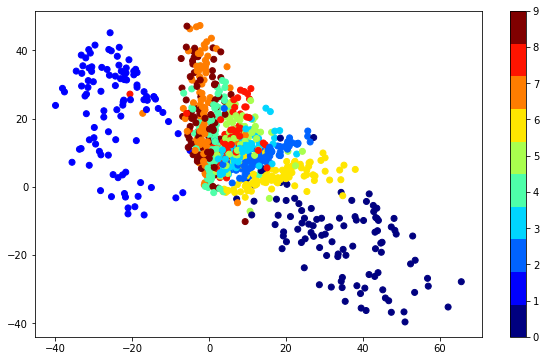

Epoch 301 / 1000 ; average loss: 46386.561923011206; Reconstruction loss :  46304.996543181885; KL loss 81.56536054892963


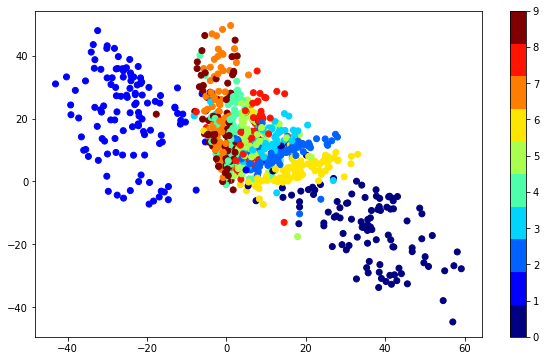

Epoch 311 / 1000 ; average loss: 47797.05797017036; Reconstruction loss :  47712.45623835234; KL loss 84.60171328108522


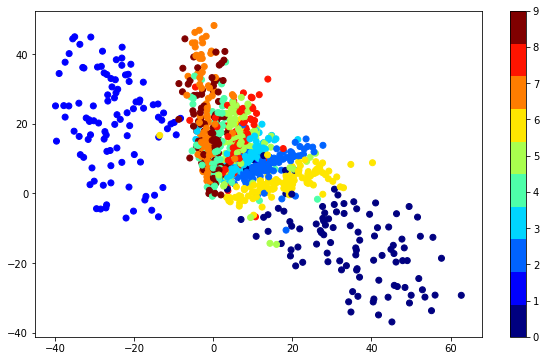

Epoch 321 / 1000 ; average loss: 49204.49294488625; Reconstruction loss :  49116.82500681826; KL loss 87.6679177865897


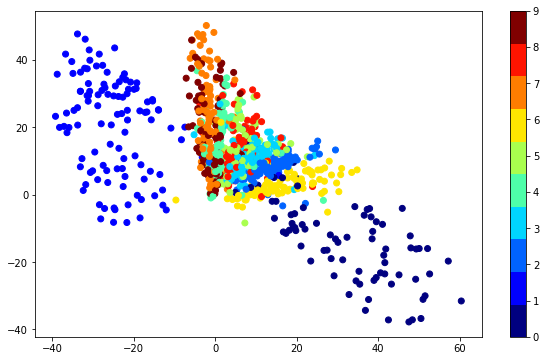

Epoch 331 / 1000 ; average loss: 50608.949144317994; Reconstruction loss :  50518.18478892044; KL loss 90.76433621365818


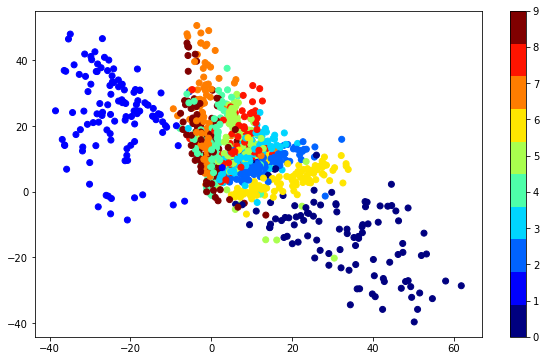

Epoch 341 / 1000 ; average loss: 52010.4942573862; Reconstruction loss :  51916.60553295451; KL loss 93.88870213107217


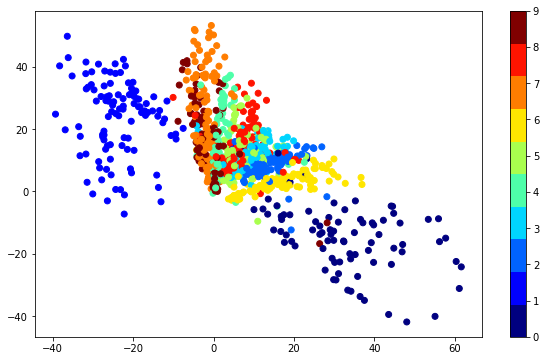

Epoch 351 / 1000 ; average loss: 53409.3302272725; Reconstruction loss :  53312.28986732952; KL loss 97.04033683566179


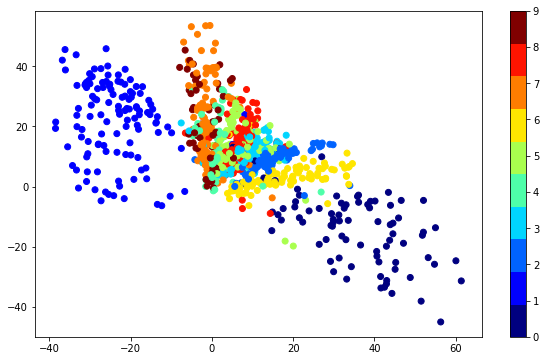

Epoch 361 / 1000 ; average loss: 54805.53646306796; Reconstruction loss :  54705.31996221592; KL loss 100.21647647744088


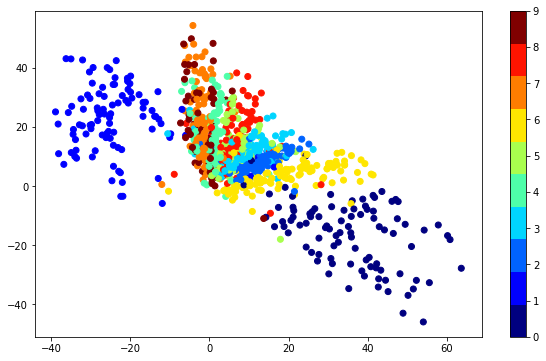

Epoch 371 / 1000 ; average loss: 56199.147715908846; Reconstruction loss :  56095.73221363638; KL loss 103.41547753279421


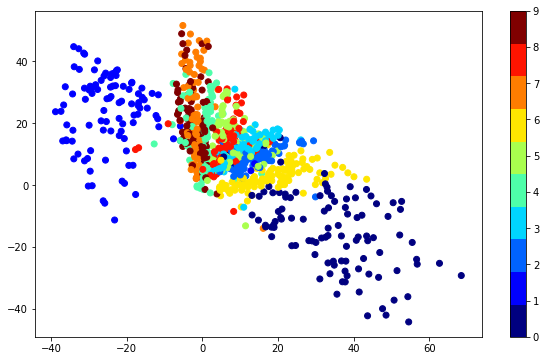

Epoch 381 / 1000 ; average loss: 57590.25574261344; Reconstruction loss :  57483.61796335234; KL loss 106.63775798267875


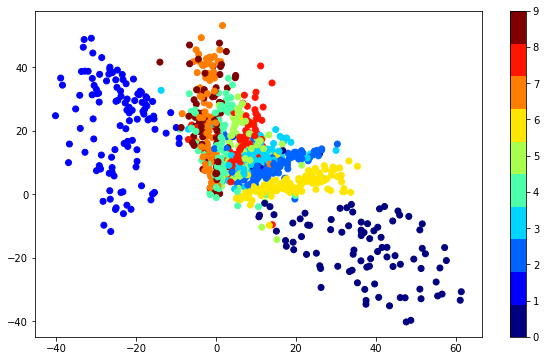

Epoch 391 / 1000 ; average loss: 58978.9897610794; Reconstruction loss :  58869.10801590914; KL loss 109.88172405989366


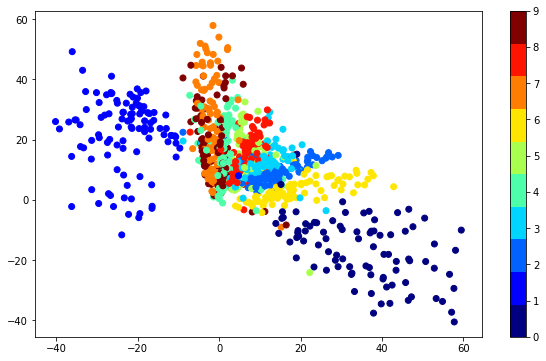

Epoch 401 / 1000 ; average loss: 60365.38571590892; Reconstruction loss :  60252.23946676142; KL loss 113.14622623607421


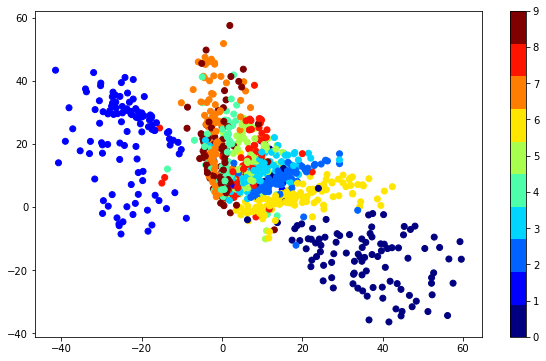

Epoch 411 / 1000 ; average loss: 61749.497773295196; Reconstruction loss :  61633.067723579574; KL loss 116.43003184076626


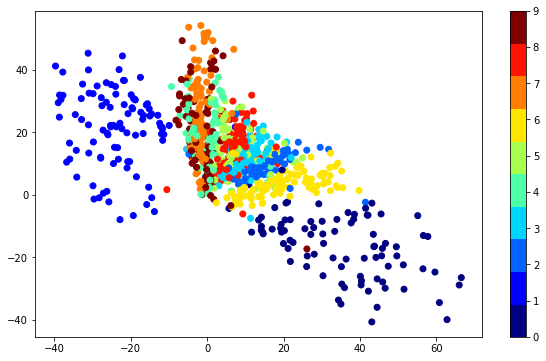

Epoch 421 / 1000 ; average loss: 63131.424742329305; Reconstruction loss :  63011.69175397723; KL loss 119.7329726827185


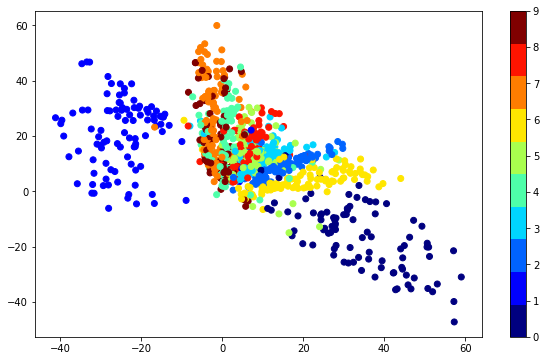

Epoch 431 / 1000 ; average loss: 64511.204036931515; Reconstruction loss :  64388.14988948857; KL loss 123.05412883228789


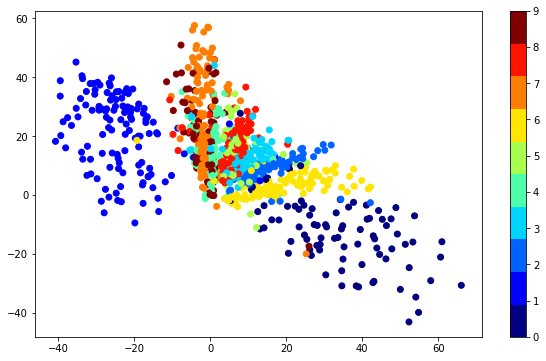

Epoch 441 / 1000 ; average loss: 65888.96472755661; Reconstruction loss :  65762.57399318181; KL loss 126.3907160615138


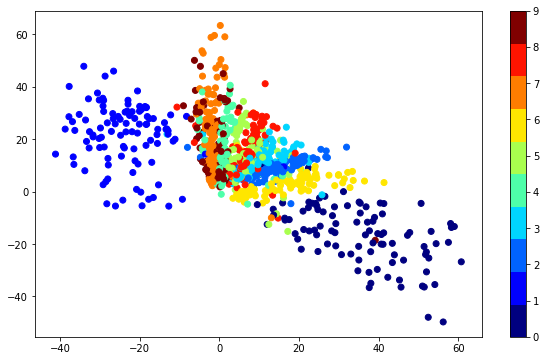

Epoch 451 / 1000 ; average loss: 67264.63450795418; Reconstruction loss :  67134.8897235794; KL loss 129.74476244878713


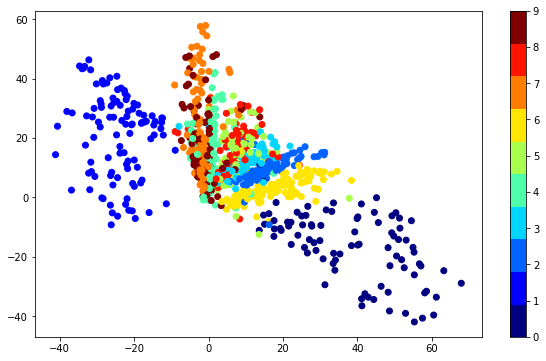

Epoch 461 / 1000 ; average loss: 68638.38192272716; Reconstruction loss :  68505.26729204546; KL loss 133.11460775629376


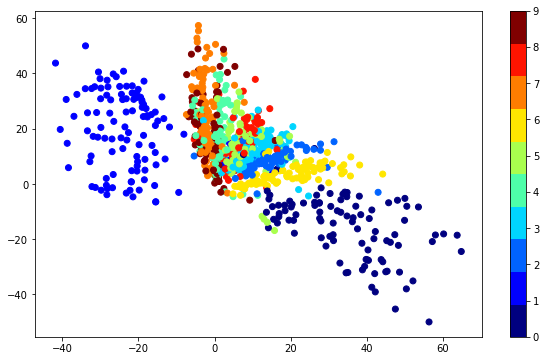

Epoch 471 / 1000 ; average loss: 70010.21404318155; Reconstruction loss :  69873.71632045461; KL loss 136.4977034666321


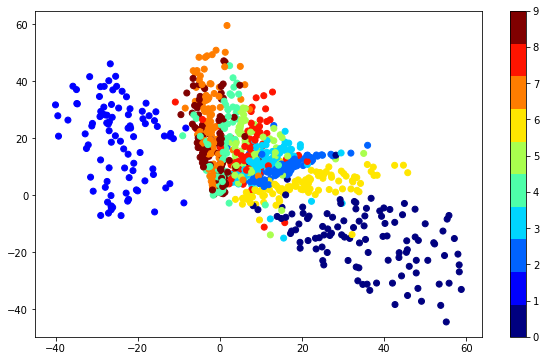

Epoch 481 / 1000 ; average loss: 71380.17705426106; Reconstruction loss :  71240.28164829557; KL loss 139.89538687727656


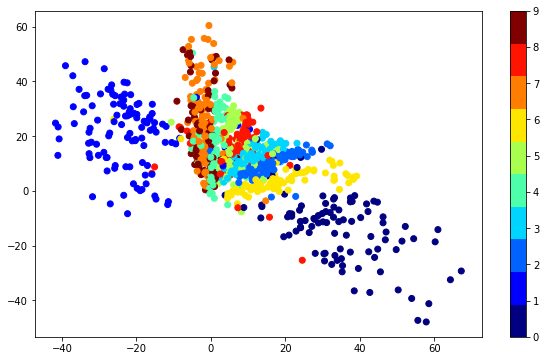

Epoch 491 / 1000 ; average loss: 72748.38089034049; Reconstruction loss :  72605.07718380695; KL loss 143.30368702209643


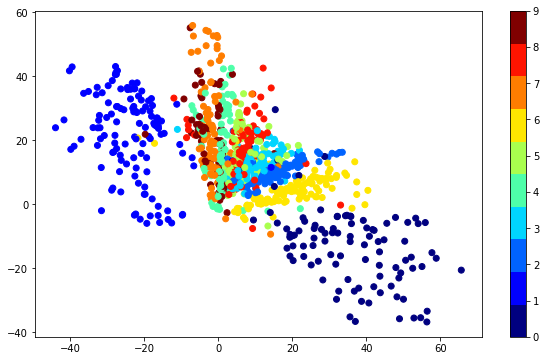

Epoch 501 / 1000 ; average loss: 74114.77844687442; Reconstruction loss :  73968.0530647728; KL loss 146.72536783375293


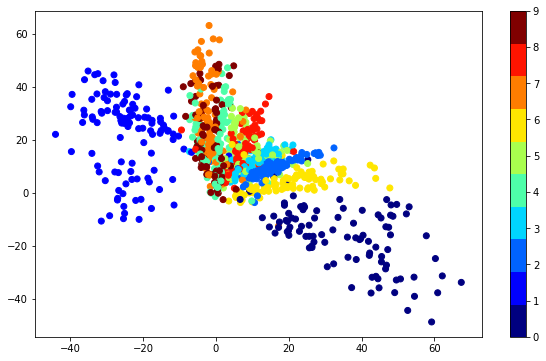

Epoch 511 / 1000 ; average loss: 75479.4472012778; Reconstruction loss :  75329.28883224438; KL loss 150.15835178428108


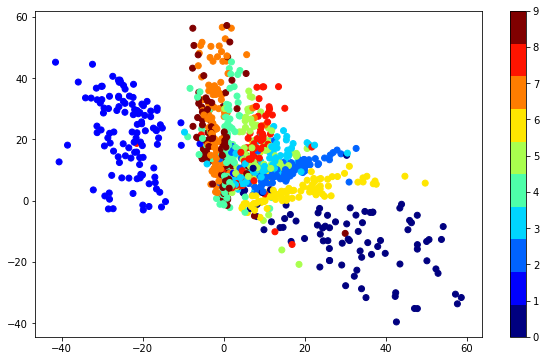

Epoch 521 / 1000 ; average loss: 76842.45929928923; Reconstruction loss :  76688.85553281252; KL loss 153.60374932456443


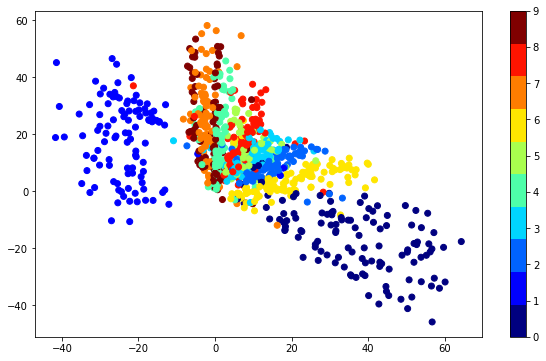

Epoch 531 / 1000 ; average loss: 78203.83007798239; Reconstruction loss :  78046.77226122157; KL loss 157.0577990876372


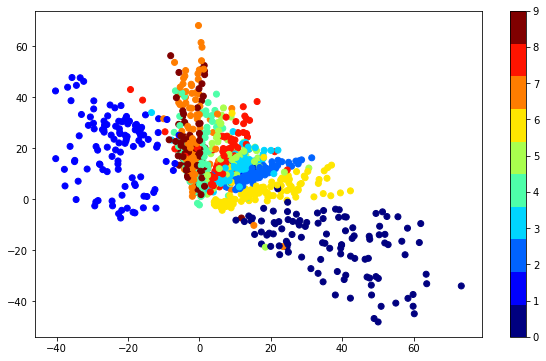

Epoch 541 / 1000 ; average loss: 79563.61289815292; Reconstruction loss :  79403.09121321002; KL loss 160.5216670009006


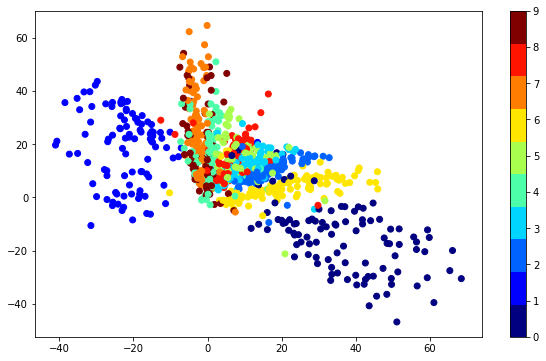

Epoch 551 / 1000 ; average loss: 80921.84973508478; Reconstruction loss :  80757.85549673282; KL loss 163.99422149253297


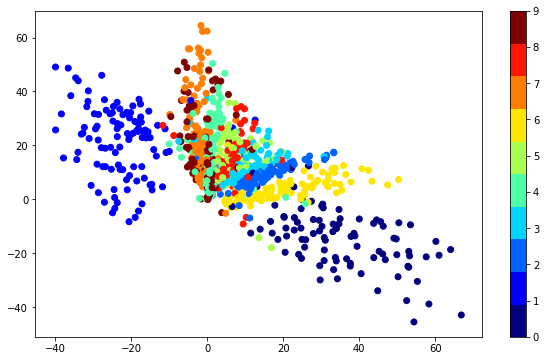

Epoch 561 / 1000 ; average loss: 82278.57896505632; Reconstruction loss :  82111.10170710218; KL loss 167.4772413500435


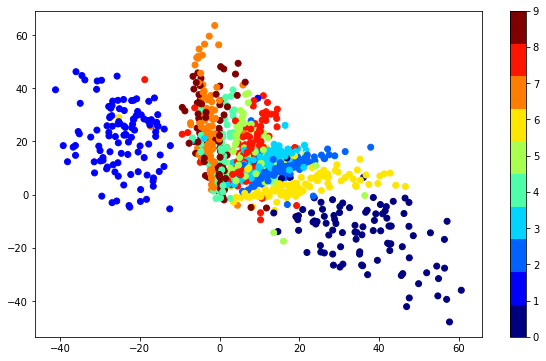

Epoch 571 / 1000 ; average loss: 83633.8180951698; Reconstruction loss :  83462.8498042614; KL loss 170.96827547757397


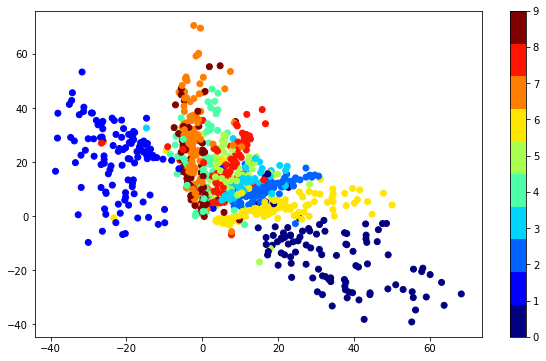

Epoch 581 / 1000 ; average loss: 84987.65631647654; Reconstruction loss :  84813.1902200285; KL loss 174.46607911304972


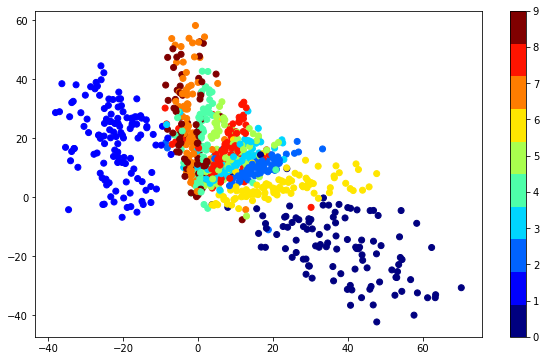

Epoch 591 / 1000 ; average loss: 86340.0623419027; Reconstruction loss :  86162.08936335238; KL loss 177.97296282554103


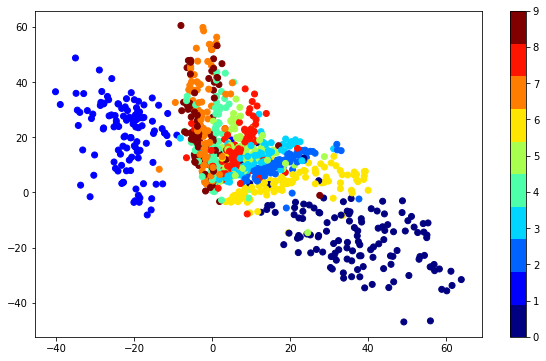

Epoch 601 / 1000 ; average loss: 87691.11190596514; Reconstruction loss :  87509.62460113638; KL loss 181.48728969932037


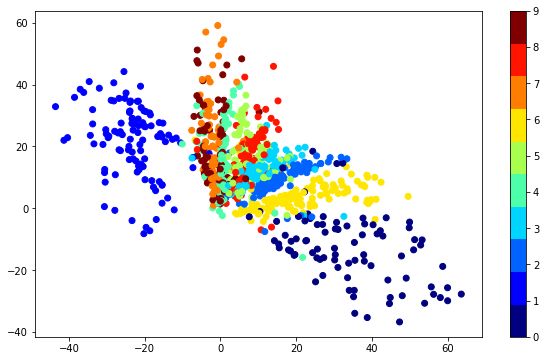

Epoch 611 / 1000 ; average loss: 89040.84285653314; Reconstruction loss :  88855.8334417613; KL loss 185.00939602089753


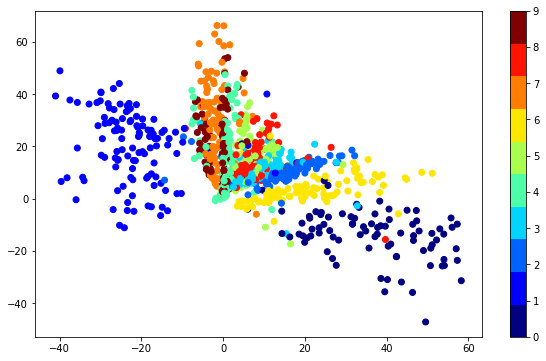

Epoch 621 / 1000 ; average loss: 90389.29702357868; Reconstruction loss :  90200.7567308238; KL loss 188.54027266607233


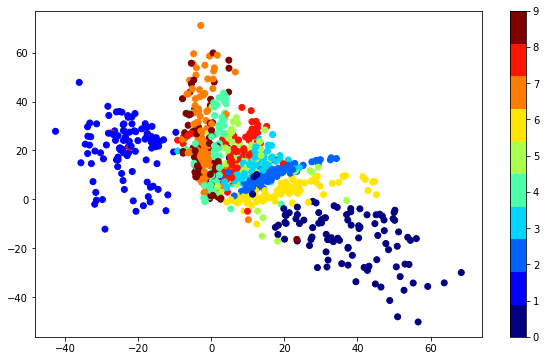

Epoch 631 / 1000 ; average loss: 91736.47998124915; Reconstruction loss :  91544.4033330966; KL loss 192.07663110778913


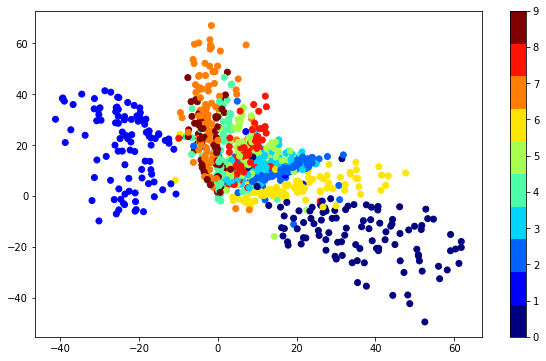

Epoch 641 / 1000 ; average loss: 93082.40584985724; Reconstruction loss :  92886.78462670468; KL loss 195.62120459578207


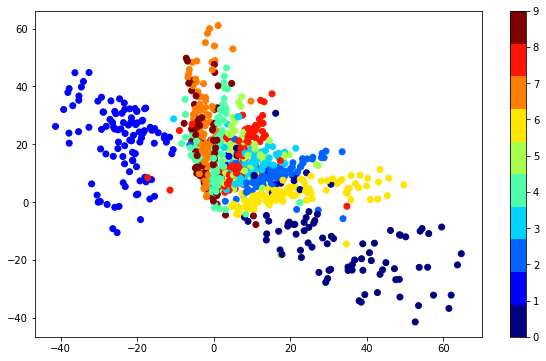

Epoch 651 / 1000 ; average loss: 94427.1271937493; Reconstruction loss :  94227.95543039791; KL loss 199.17174473472033


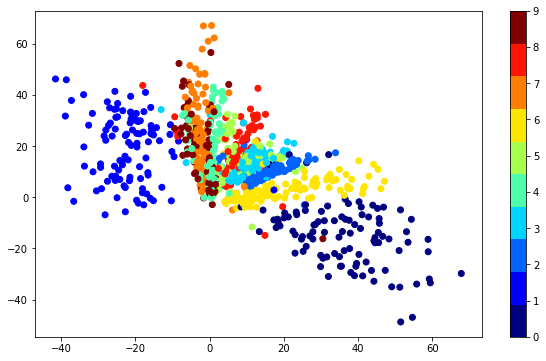

Epoch 661 / 1000 ; average loss: 95770.66249602221; Reconstruction loss :  95567.93373011376; KL loss 202.72874740084737


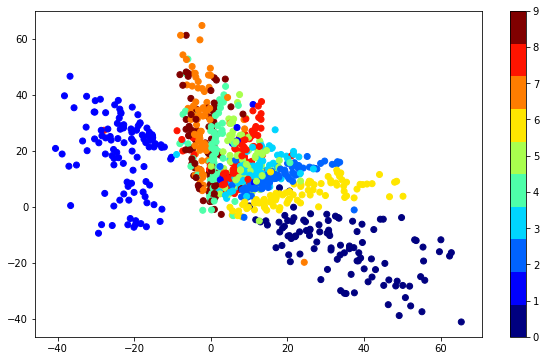

Epoch 671 / 1000 ; average loss: 97113.0759147722; Reconstruction loss :  96906.785468182; KL loss 206.2904289649011


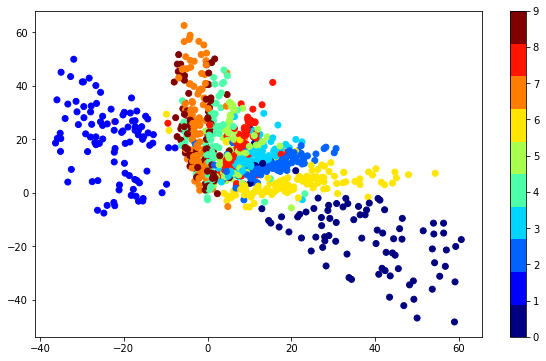

Epoch 681 / 1000 ; average loss: 98454.35833337995; Reconstruction loss :  98244.50112343766; KL loss 209.85719411160704


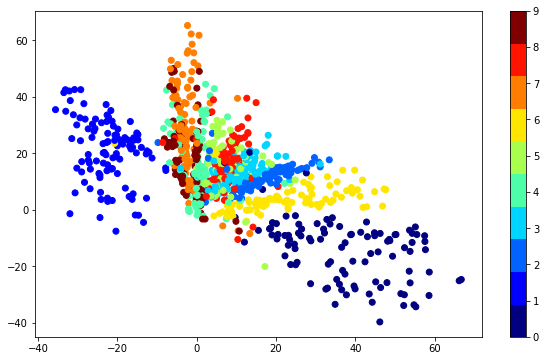

Epoch 691 / 1000 ; average loss: 99794.53753607866; Reconstruction loss :  99581.10630255713; KL loss 213.43121601712474


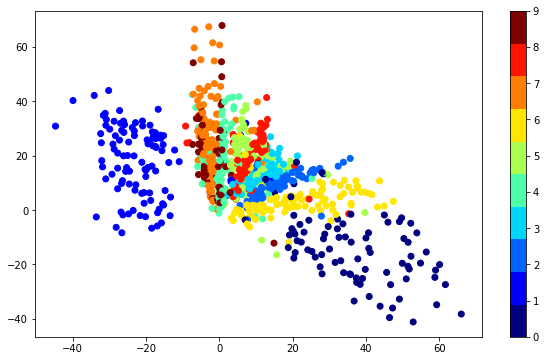

Epoch 701 / 1000 ; average loss: 101133.60437428884; Reconstruction loss :  100916.59315681846; KL loss 217.0111997529203


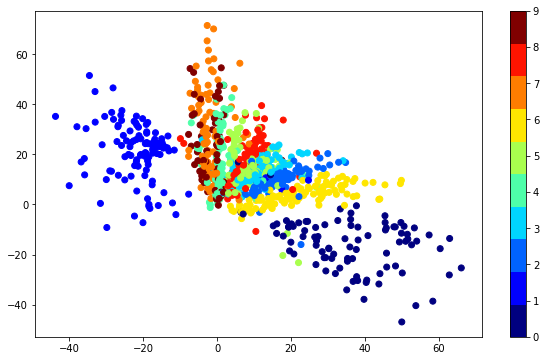

Epoch 711 / 1000 ; average loss: 102471.62010894793; Reconstruction loss :  102251.0227846595; KL loss 220.59730707269998


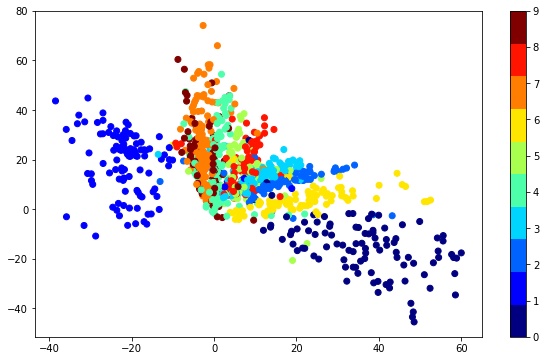

Epoch 721 / 1000 ; average loss: 103808.6326586637; Reconstruction loss :  103584.44287514253; KL loss 224.18976578685565


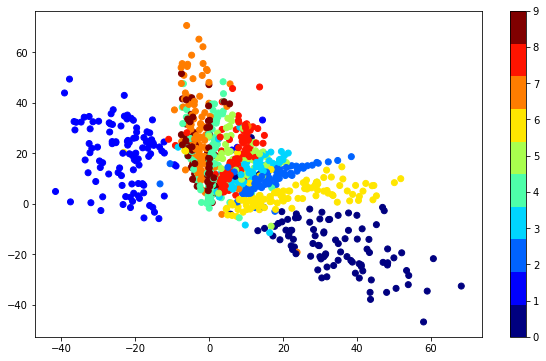

Epoch 731 / 1000 ; average loss: 105144.5588723; Reconstruction loss :  104916.77050028452; KL loss 227.78835382396508


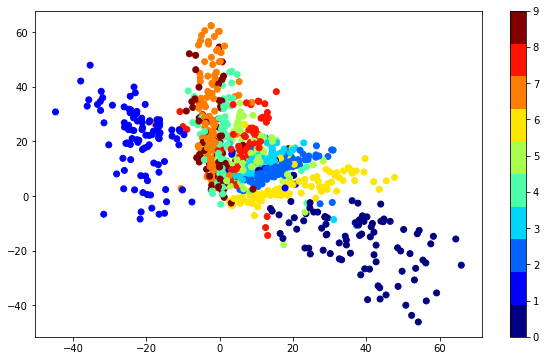

Epoch 741 / 1000 ; average loss: 106479.4674887772; Reconstruction loss :  106248.07446051163; KL loss 231.3930082811959


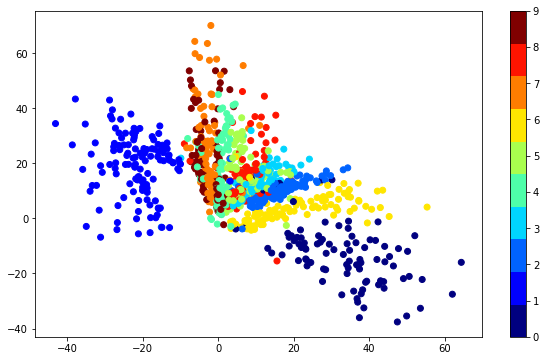

Epoch 751 / 1000 ; average loss: 107813.45410170344; Reconstruction loss :  107578.44966676168; KL loss 235.0044144440823


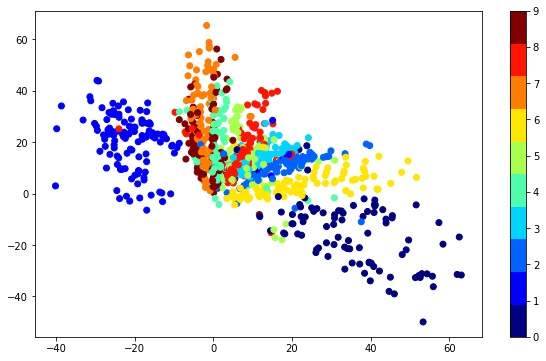

Epoch 761 / 1000 ; average loss: 109146.45529019783; Reconstruction loss :  108907.83301434673; KL loss 238.6222578733704


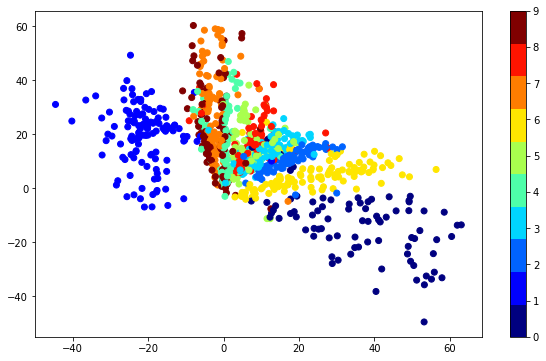

Epoch 771 / 1000 ; average loss: 110478.53486292508; Reconstruction loss :  110236.28807897752; KL loss 242.24676752968728


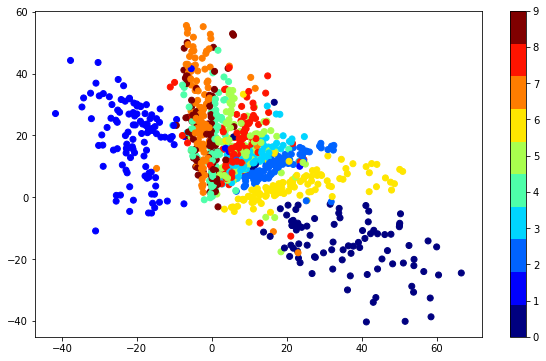

Epoch 781 / 1000 ; average loss: 111809.65128451596; Reconstruction loss :  111563.7716600854; KL loss 245.87960568831204


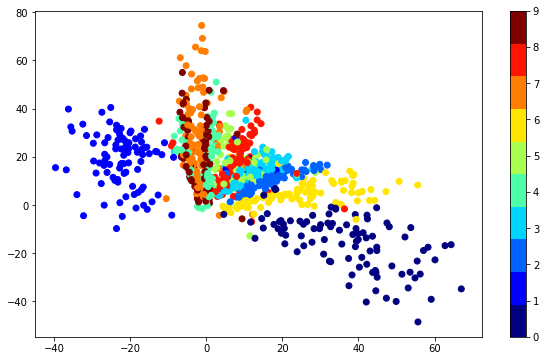

Epoch 791 / 1000 ; average loss: 113139.88144119206; Reconstruction loss :  112890.36292911942; KL loss 249.51849248529822


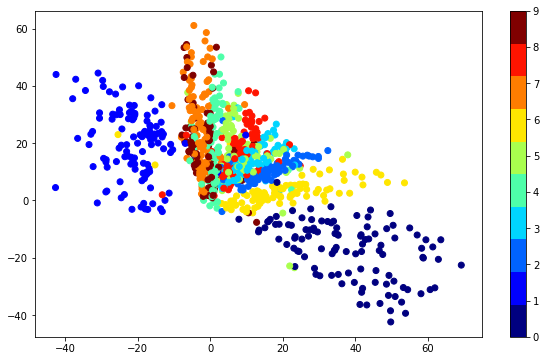

Epoch 801 / 1000 ; average loss: 114469.22363167496; Reconstruction loss :  114216.05917372162; KL loss 253.16443944408297


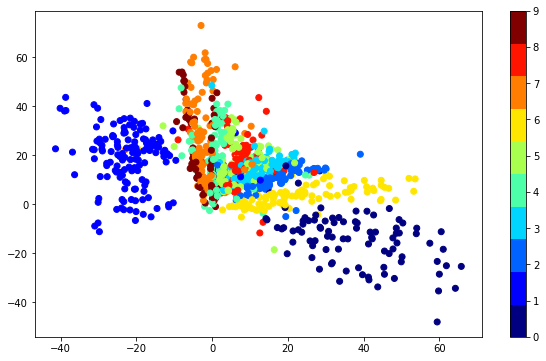

Epoch 811 / 1000 ; average loss: 115797.60432158953; Reconstruction loss :  115540.78572002846; KL loss 256.81858360579326


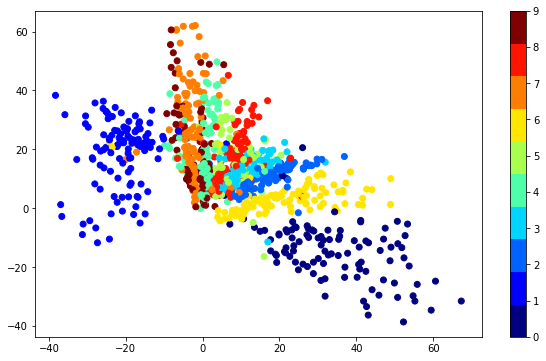

KeyboardInterrupt: 

In [11]:
for epoch in range(hm_epochs):

    for _ in range(int(mnist.train.num_examples/vae.batch_size)):
        epoch_x, epoch_label = mnist.train.next_batch(vae.batch_size)
        epoch_label = np.argmax(epoch_label,axis=1)
        _, c, recon, kl = vae.fit(np.rint(epoch_x).astype(np.float32))
        epoch_loss += c/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        recon_loss += recon/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        kl_loss += kl/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        history_loss.append(epoch_loss)
        history_recon.append(recon_loss)
        history_kl.append(kl_loss)
        
    if epoch % 10 is 0:
        print('Epoch', epoch+1, '/',hm_epochs,'; average loss:',epoch_loss, end='; ')
        print('Reconstruction loss : ', recon_loss, end='; ')
        print('KL loss', kl_loss)
        
        z_mu = vae.get_z_mean(np.rint(epoch_x).astype(np.float32))
        list_of_z_mu.append(z_mu)
        plt.close()
        plt.figure(figsize=(10, 6))
        draw_digits_latent_space(z_mu, epoch_label)
        plt.show()

#### Only use this section if saving model

In [89]:
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = 'saved_models/vae-fc-'
saved_filename = filename+timestr
saver.save(vae.sess,filename+timestr)

'saved_models/vae-fc-20181029-171037'

#### Restoring model weights

In [90]:
saver.restore(vae.sess, 'saved_models/vae-fc-20181029-171037')

INFO:tensorflow:Restoring parameters from saved_models/vae-fc-20181029-171037


#### Visualise data reconstruction

In [110]:
test_epoch, _ = mnist.train.next_batch(vae.batch_size)
x_tst = vae.reconstruct_X(np.rint(test_epoch).astype(np.float32))

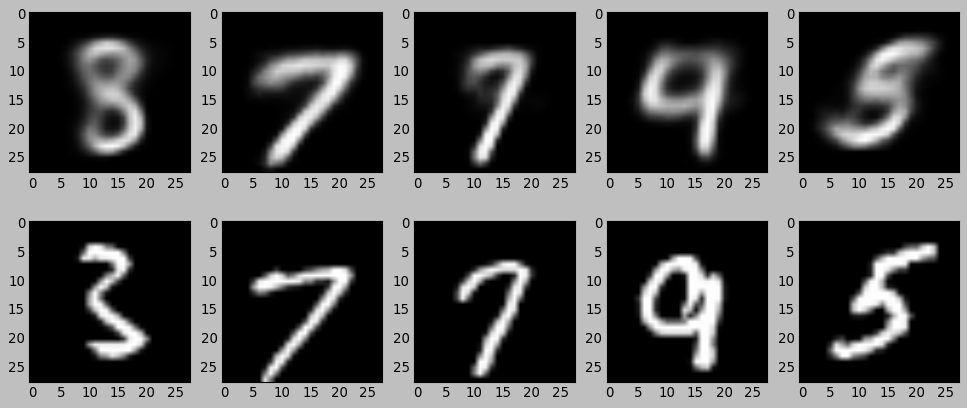

In [111]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
axs = axs.ravel()
n = 0
j = 0

for i in range(n,n+5):
    axs[j].imshow(x_tst[i,:].reshape([28,28]),cmap='gray')
    axs[j+5].imshow(test_epoch[i,:].reshape([28,28]),cmap='gray')
    j += 1
    
plt.show()

#### Visualise latent space

In [84]:
test_epoch, test_label = mnist.train.next_batch(vae.batch_size)
x_tst = vae.reconstruct_X(np.rint(test_epoch).astype(np.float32))
test_label = np.argmax(test_label,axis=1)

In [85]:
z_mean_test = vae.sess.run(vae.z_mu, {vae.x: x_tst})

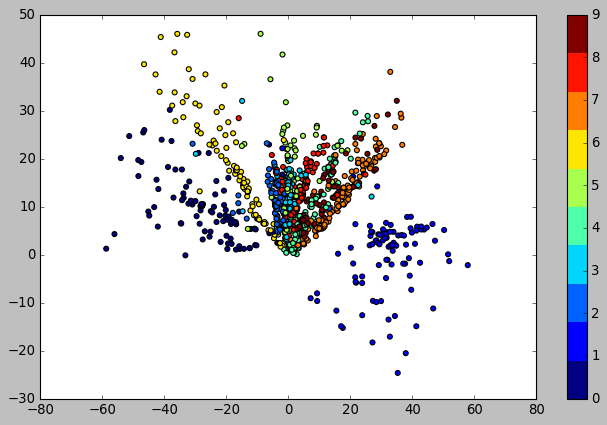

In [116]:
plt.figure(figsize=(10, 6))
plt.scatter(z_mean_test[:,0],z_mean_test[:,1],c=test_label,cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar()
plt.show()

In [98]:
from sklearn import decomposition

In [100]:
pca = decomposition.PCA(n_components=2)
pca.fit(z_mean_test)
z_pca = pca.transform(z_mean_test)

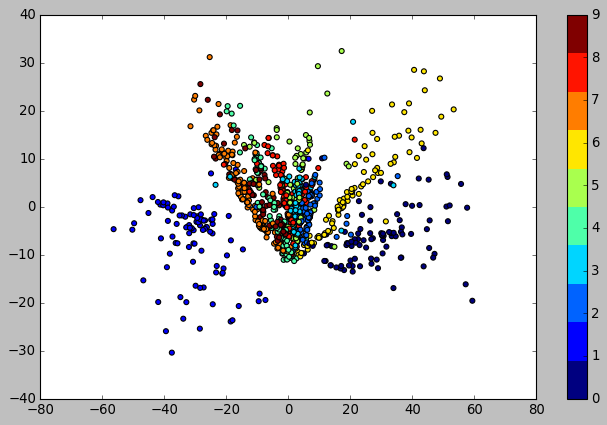

In [101]:
plt.figure(figsize=(10, 6))
plt.scatter(z_pca[:,0],z_pca[:,1],c=test_label,cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar()
plt.show()